In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def compute_mean(sample):
    dimension = sample.shape[0]
    sum_vector = np.zeros((dimension,1))
    sum_vector = sum_vector.flatten('F') 
    
    for x in range(sample.shape[1]):
        sum_vector = sum_vector + sample[:,x].flatten('F')

    return (sum_vector/sample.shape[1]).T

In [3]:
def compute_cov(sample):
    mean = compute_mean(sample)
    dimension = sample.shape[0]
    err_sum_vector = np.zeros((dimension, dimension))
    
    for x in range(sample.shape[1]):
        err_vector = sample[:,x].flatten('F').T - mean
        err_sum_vector = err_sum_vector + np.dot(err_vector, err_vector.T)
        
    return (err_sum_vector/(sample.shape[1]-1))

In [4]:

def compute_prior(samples):
    total_sample = 0
    for sample in samples:
        total_sample = total_sample + sample.shape[1]
        
    prior = []
    for sample in samples:
        prior.append(sample.shape[1]/total_sample)
        
    return prior

In [5]:
train_cat = np.matrix(np.loadtxt('train_cat.txt', delimiter = ','))
train_grass = np.matrix(np.loadtxt('train_grass.txt', delimiter = ','))

cat_mean = compute_mean(train_cat)
grass_mean = compute_mean(train_grass)
cat_cov = compute_cov(train_cat)
grass_cov = compute_cov(train_grass)
prior_prob = compute_prior([train_grass, train_cat])

In [6]:
print(cat_mean.shape)

(64, 1)


In [7]:
print(cat_cov.shape)

(64, 64)


In [8]:
params = [{
    'class': 'grass',
    'value': 0,
    'mean': grass_mean,
    'cov': grass_cov,
    'inv_cov': np.linalg.inv(grass_cov),
    'det_cov': np.linalg.det(grass_cov),
    'log_det_cov': (1/2) * np.log(np.linalg.det(grass_cov)),
    'prior_prob': prior_prob[0],
    'log_prior_prob': np.log(prior_prob[0])
    }, {
    'class': 'cat',
    'value': 1,
    'mean': cat_mean,
    'cov': cat_cov,
    'inv_cov': np.linalg.inv(cat_cov),
    'det_cov': np.linalg.det(cat_cov),
    'log_det_cov': (1/2) * np.log(np.linalg.det(cat_cov)),
    'prior_prob': prior_prob[1],
    'log_prior_prob': np.log(prior_prob[1])
    }]

In [9]:
d = train_cat.shape[0]
pi_term = (d/2) * np.log(2*np.pi)
W = params[0]['inv_cov'] - params[1]['inv_cov']
w = np.dot(params[1]['inv_cov'], params[1]['mean']) - np.dot(params[0]['inv_cov'], params[0]['mean'])

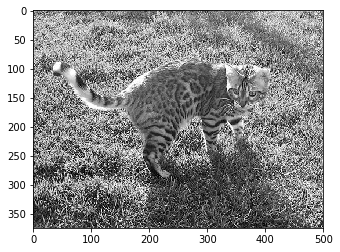

In [91]:
original_image = plt.imread('cat_grass.jpg') / 255
original_image = original_image.astype('float32')
plt.imshow(original_image*255, cmap = 'gray')

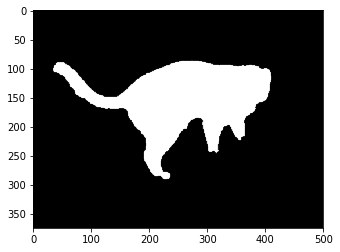

In [11]:
ground_truth = plt.imread('truth.png')  
plt.imshow(ground_truth, cmap = 'gray')

In [12]:
def g_x(x, param):
    diff = (x - param['mean'])
    return (param['log_prior_prob']
            - pi_term
            - param['log_det_cov']
            - (1/2) * np.dot(diff.T, np.dot(param['inv_cov'], diff)))[0, 0]

In [13]:
def gradient(x, x_0, lamb, target_index, params):
    g = []
    for param in params:
        g.append(g_x(x, param))
    if g[target_index] == max(g):
        print('glass image')
        return 0
    else:
        value = 2*(x - x_0) + lamb*(np.dot(W, x) + w) 
        return value


In [342]:
def cw_attack(x, lamb, target_index, params, alpha):
    g = []
    for param in params:
        g.append(g_x(x, param))
    if g[target_index] == max(g):
        return x
    else:
        x_0 = x
        current_x = x
        for i in range(0):
            gradient_value = 2*(x - x_0) + lamb*(np.dot(W, x) + w) 
            new_x = current_x + alpha*gradient_value
            new_x = np.clip(new_x, 0, 1)
            if np.linalg.norm(new_x - current_x) < 0.01:
                return new_x
            else: 
                current_x = new_x
        return current_x

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 15)

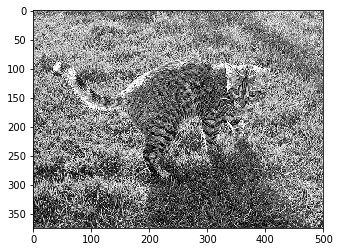

In [347]:
purturb_image = original_image.copy()
max_iteraton = 10
alpha = 0.001
lamb = 5
for iteration in range(max_iteraton):
    new_image = purturb_image.copy()
#     print(iteration)
    for i in range(original_image.shape[0]-8):
        for j in range(original_image.shape[1]-8):
#     for i in range(90, 120):
#         for j in range(50, 100):
            x_0 = original_image[i:i+8, j:j+8]
            x_0 = x_0.reshape((d, 1))
            x = purturb_image[i:i+8, j:j+8]
            x = x.reshape((d, 1))
            g = []
            for param in params:
                g.append(g_x(x, param))
            if g[0] > g[1]:
                continue
            else:
                gradient_value = 2*(x - x_0) + lamb*(np.dot(W, x) + w)
                new_x = x - alpha*gradient_value
                new_x = np.clip(new_x, 0, 1)
#                 if np.linalg.norm(new_x - x) > 0.01:
#                     new_image[i:i+8, j:j+8] = new_x.reshape((8, 8))
                new_image[i:i+8, j:j+8] = new_x.reshape((8, 8))
#             value = x.reshape((8, 8))
    #         value = cw_attack(x, 1, 0, params, 0.1).reshape((8, 8))
    
    if np.linalg.norm(new_image - purturb_image) < 0.01:
#         print(iteration)
        break
    else: 
        purturb_image = new_image.copy()
           
plt.imshow(purturb_image, cmap = 'gray')

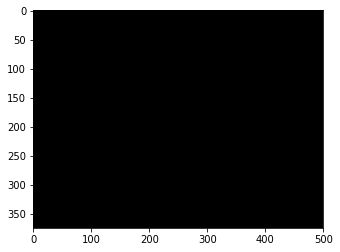

In [348]:
test = np.zeros((original_image.shape[0], original_image.shape[1]))
for i in range(purturb_image.shape[0]-8):
    for j in range(purturb_image.shape[1]-8):
        x = purturb_image[i:i+8, j:j+8]
        x = x.reshape((d, 1))
        g_glass = g_x(x, params[0])
        g_cat = g_x(x, params[1])
        
        if g_glass > g_cat:
            value = 0
        else:
            value = 1
        
        for m in range(8):
             for n in range(8):
                try:
                    test[i+m, j+n] = value
                except IndexError:
                    print(f'({i}+{m}, {j}+{n})')
plt.imshow(test, cmap = 'gray')
# plt.savefig("final_3_1_4.pdf") 

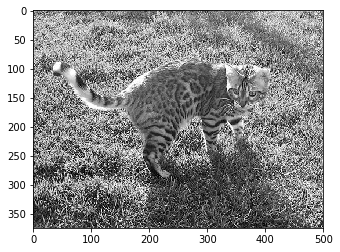

In [321]:
plt.imshow(original_image, cmap = 'gray')

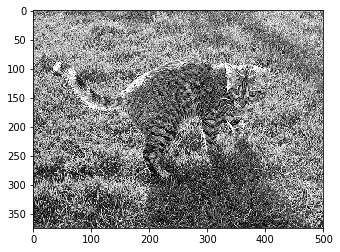

In [322]:
plt.imshow(purturb_image, cmap = 'gray')
plt.savefig("final_3_1_1.pdf") 

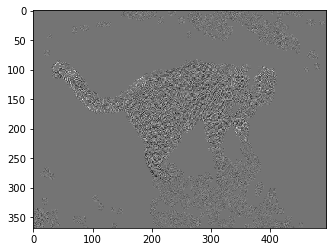

In [323]:
purturb = original_image[:368,:496]-purturb_image[:368,:496]
plt.imshow(purturb, cmap = 'gray')
plt.savefig("final_3_1_2.pdf") 

In [324]:
print(np.linalg.norm(purturb))

29.156866


In [145]:
print(original_image)

[[0.627451   0.28627452 0.46666667 ... 0.4862745  0.5411765  0.34901962]
 [0.627451   0.34117648 0.70980394 ... 0.627451   0.39607844 0.24313726]
 [0.4745098  0.5137255  0.80784315 ... 0.59607846 0.30588236 0.59607846]
 ...
 [0.57254905 0.69411767 0.19215687 ... 0.9882353  0.10588235 0.        ]
 [0.43137255 0.7764706  0.21960784 ... 0.9098039  0.5137255  0.36078432]
 [0.37254903 0.49411765 0.41568628 ... 0.41568628 0.6666667  0.7764706 ]]


In [146]:
print(purturb_image[:368,:496])

[[0.627451   0.28627452 0.46666667 ... 0.2784314  0.83137256 0.4509804 ]
 [0.627451   0.34117648 0.70980394 ... 0.7764706  0.7176471  0.24705882]
 [0.4745098  0.5137255  0.80784315 ... 0.94509804 0.03529412 0.36862746]
 ...
 [0.18431373 0.19607843 0.15686275 ... 0.84313726 0.9019608  0.21176471]
 [0.26666668 0.27058825 0.19607843 ... 0.78039217 0.95686275 0.627451  ]
 [0.24313726 0.3254902  0.38039216 ... 0.92941177 0.6666667  0.33333334]]


In [147]:
purturb[88:93, 47:52]

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.16373861,  0.117118  ],
       [ 0.        ,  0.        ,  0.        , -0.23079452,  0.04438573],
       [ 0.        ,  0.        ,  0.        , -0.01665297,  0.13487422]],
      dtype=float32)

In [148]:
print(original_image[88:93, 47:52])

[[0.59607846 0.4509804  0.7529412  0.7921569  0.4392157 ]
 [0.94509804 0.5882353  0.5411765  0.62352943 0.5803922 ]
 [1.         0.93333334 0.46666667 0.6627451  0.60784316]
 [0.9764706  0.972549   0.52156866 0.4117647  0.5137255 ]
 [1.         0.7882353  0.5568628  0.34509805 0.3764706 ]]


In [149]:
print(purturb_image[88:93, 47:52])

[[0.59607846 0.4509804  0.7529412  0.7921569  0.4392157 ]
 [0.94509804 0.5882353  0.5411765  0.62352943 0.5803922 ]
 [1.         0.93333334 0.46666667 0.4990065  0.49072516]
 [0.9764706  0.972549   0.52156866 0.64255923 0.4693398 ]
 [1.         0.7882353  0.5568628  0.36175102 0.24159637]]


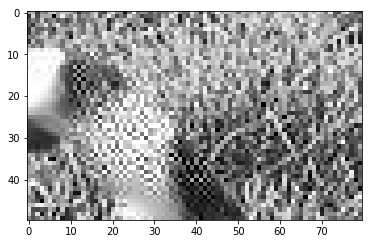

In [150]:
plt.imshow(purturb_image[80:130, 40:120], cmap = 'gray')

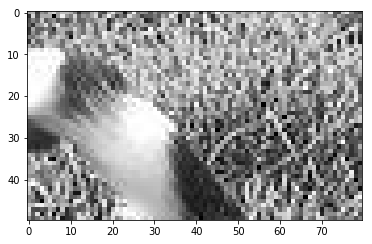

In [151]:
plt.imshow(original_image[80:130, 40:120], cmap = 'gray')